In [12]:
import os
from datetime import datetime
 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [13]:
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 4.3MB/s 


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
#get correct directory
os.chdir('/content/drive/MyDrive/Love Hackathon')

In [27]:
#from .py
import utils

In [ ]:
'''
https://medium.datadriveninvestor.com/a-survey-of-evaluation-metrics-for-multilabel-classification-bb16e8cd41cd
'''

In [ ]:
#read df
df = pd.read_csv('data/Demographic to Gift Preference Survey.csv')

#convert to correct dtypes
df['Birthday'] = df['Birthday'].apply(lambda _: datetime.strptime(_,"%Y-%m-%d"))

#create necessary columns
df['Age'] = datetime.now().year - df['Birthday'].apply(lambda x: x.year)

#remove outliers
df['Age'] = df['Age'].apply(lambda x: x if (x >18 and x <60) else df['Age'].median()) #use median to impute age

#remove unnecessary columns
df = df.drop(['Timestamp', 'Birthday', 'Relationship Period (Starting Date)'], axis=1)

#rename for readability
df.rename(columns={'Hobby (Select 3)': 'Hobby', 'Gift Preferences (Choose 3)': 'Gift Preferences'}, inplace=True)

#Handle single feature with multiple values through one-hot encoding
multi_val_cols = ['Hobby', 'Movie Preferences', 'Gift Preferences']
new_df = utils.multi_cat_val_handler(df, multi_val_cols)
new_df = pd.get_dummies(new_df, drop_first=True)

#remove weird col
new_df.drop(['g_A smile HAHAHAHA'], axis=1, inplace=True)
new_df.drop(['g_I would choose all'], axis=1, inplace=True)
new_df.drop(['g_Not necessarily'], axis=1, inplace=True)

#remove NAN in movie - NAN means they don't like all movie 
for col in new_df.columns:
  if col.startswith('m_'):
    new_df[col] = new_df[col].fillna(0)

In [ ]:
def get_count_val(df):
    col_list = df.columns
    col_val = []
    for col in df.columns:
        col_val.append( df[col].value_counts()[1])

    plt.barh(col_list, col_val)
    plt.title('Gift Preferences')
    plt.xlabel('Label count')
    plt.show()
    
mask = new_df.columns.str.contains(r'g_.*')
get_count_val(new_df.iloc[:, mask])

In [15]:
new_df.describe()

NameError: ignored

In [16]:
utils.check_df(new_df, show_unique=True)

NameError: ignored

# Train & Test Datasets

In [17]:
mask = new_df.columns.str.contains(r'g_.*')
y = new_df.iloc[:, mask]
X_master = new_df.drop(y.columns, axis=1)

corr_df = pd.concat([X_master,y],axis=1)
corr = corr_df.corr()
# corr.style.background_gradient(cmap='coolwarm').set_precision(2)

corr_v1 = corr.iloc[-12:, :-12]
column_master = corr_v1.columns
columns_select = np.full(len(column_master), False, dtype=bool)

'''
columnName = corrent column name
columnData = series of the column
Idea: To loop through each columns and remove the columns if all are negative
'''
selection_threshold = 0.15

for index, (columnName, columnData) in enumerate(corr_v1.iteritems()):
    for s in columnData:
        flag = False
        if s > selection_threshold:
            flag =True
            break
    if flag == True:
        columns_select[index] = True

columns_select_converted = corr_v1.columns[columns_select]

NameError: ignored

In [ ]:
corr_v1[columns_select_converted]

In [ ]:
# from sklearn.decomposition import PCA
# mask = new_df.columns.str.contains(r'g_.*')
# y = new_df.iloc[:, mask]
# X_master = new_df.drop(y.columns, axis=1)
# #only select columns from after filtering using correlation
# X = X_master[columns_select_converted]

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)
# y = y.to_numpy()

# #test PCA
# pca = PCA(n_components=20)
# principalComponents = pca.fit_transform(X)
# principalDf = pd.DataFrame(data = principalComponents)

# X_train, X_test, y_train, y_test = train_test_split(principalDf, y, test_size=0.20, random_state=42)
X, y, X_train, X_test, y_train, y_test = utils.get_dataset()

In [18]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=35)
# pca.fit(X)
# X = pca.transform(X)

In [19]:
'''
'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
'''

"\n'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.\n'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.\n'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.\n"

In [20]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

def cross_validate_models(models, X, y):
    '''
    cross_validate and return the best model.
    '''
    features = ['Models',
                'test_f1_macro_mean', 'test_f1_macro_std', 'train_f1_macro_mean', 'train_f1_macro_std',
                'test_f1_weighted_mean', 'test_f1_weighted_std', 'train_f1_weighted_mean', 'train_f1_weighted_std',
                'test_f1_micro_mean', 'test_f1_micro_std', 'train_f1_micro_mean', 'train_f1_micro_std',
                'test_recall_weighted_mean', 'test_recall_weighted_std', 'train_recall_weighted_mean', 'train_recall_weighted_std',
                'test_recall_macro_mean', 'test_recall_macro_std', 'train_recall_macro_mean', 'train_recall_macro_std',
                'test_recall_micro_mean', 'test_recall_micro_std', 'train_recall_micro_mean', 'train_recall_micro_std',
                'test_precision_weighted_mean', 'test_precision_weighted_std', 'train_precision_weighted_mean', 'train_precision_weighted_std', 
                'test_precision_macro_mean', 'test_precision_macro_std', 'train_precision_macro_mean', 'train_precision_macro_std', 
                'test_precision_micro_mean', 'test_precision_micro_std', 'train_precision_micro_mean', 'train_precision_micro_std', 
                ]
                
    scoring =['f1_weighted', 'f1_macro', 'f1_micro', 
              'recall_weighted', 'recall_macro', 'recall_micro',
              'precision_weighted', 'precision_macro', 'precision_micro']
    
    df = pd.DataFrame(columns = features) 

    best_f1_macro_mean = 0
    best_model = None

    for index, model in enumerate(models):
        #drop all columns that has NAN
#             X = df_32_X.drop(col, axis=1)
        rkf = RepeatedKFold(n_splits=5, n_repeats=15, random_state=42) #since dataset is low, cv=~5 (5 folds) and repeat 15 times
        cv = cross_validate(model, X, y, cv=rkf, return_train_score=True, scoring=scoring)

        info = pd.Series({'Models':model, 
                          
                          'test_f1_macro_mean':cv['test_f1_macro'].mean(), 'test_f1_macro_std':cv['test_f1_macro'].std(), 
                          'train_f1_macro_mean':cv['train_f1_macro'].mean(), 'train_f1_macro_std':cv['train_f1_macro'].std(),

                          'test_f1_weighted_mean':cv['test_f1_weighted'].mean(), 'test_f1_weighted_std':cv['test_f1_weighted'].std(), 
                          'train_f1_weighted_mean':cv['train_f1_weighted'].mean(), 'train_f1_weighted_std':cv['train_f1_weighted'].std(),

                          'test_f1_micro_mean':cv['test_f1_micro'].mean(), 'test_f1_micro_std':cv['test_f1_micro'].std(), 
                          'train_f1_micro_mean':cv['train_f1_micro'].mean(), 'train_f1_micro_std':cv['train_f1_micro'].std(),

                          'test_recall_weighted_mean':cv['test_recall_weighted'].mean(), 'test_recall_weighted_std':cv['test_recall_weighted'].std(), 
                          'train_recall_weighted_mean':cv['train_recall_weighted'].mean(), 'train_recall_weighted_std':cv['train_recall_weighted'].std(),

                          'test_recall_macro_mean':cv['test_recall_macro'].mean(), 'test_recall_macro_std':cv['test_recall_macro'].std(), 
                          'train_recall_macro_mean':cv['train_recall_macro'].mean(), 'train_recall_macro_std':cv['train_recall_macro'].std(),

                          'test_recall_micro_mean':cv['test_recall_micro'].mean(), 'test_recall_micro_std':cv['test_recall_micro'].std(), 
                          'train_recall_micro_mean':cv['train_recall_micro'].mean(), 'train_recall_micro_std':cv['train_recall_micro'].std(),

                          'test_precision_weighted_mean':cv['test_precision_weighted'].mean(), 'test_precision_weighted_std':cv['test_precision_weighted'].std(), 
                          'train_precision_weighted_mean':cv['train_precision_weighted'].mean(), 'train_precision_weighted_std':cv['train_precision_weighted'].std(),

                          'test_precision_macro_mean':cv['test_precision_macro'].mean(), 'test_precision_macro_std':cv['test_precision_macro'].std(), 
                          'train_precision_macro_mean':cv['train_precision_macro'].mean(), 'train_precision_macro_std':cv['train_precision_macro'].std(),

                          'test_precision_micro_mean':cv['test_precision_micro'].mean(), 'test_precision_micro_std':cv['test_precision_micro'].std(), 
                          'train_precision_micro_mean':cv['train_precision_micro'].mean(), 'train_precision_micro_std':cv['train_precision_micro'].std(),                          

                         })
                     
        df.loc[index] = info

        if best_f1_macro_mean < cv['test_f1_macro'].mean() and cv['train_f1_macro'].mean() >= 0.8:
            best_f1_macro_mean = cv['test_f1_macro'].mean()
            best_model = model

    display(df)
    print(f'The best model is \n {best_model} \n with f1_macro score: {best_f1_macro_mean}')
    return df, best_model, best_f1_macro_mean

In [21]:
'''
tree.DecisionTreeClassifier
tree.ExtraTreeClassifier
ensemble.ExtraTreesClassifier
neighbors.KNeighborsClassifier
neural_network.MLPClassifier
neighbors.RadiusNeighborsClassifier
ensemble.RandomForestClassifier
linear_model.RidgeClassifierCV
'''

scoring = ['f1_weighted', 'f1_macro', 'f1_micro', 
           'recall_weighted', 'recall_macro', 'recall_micro',
           'precision_weighted', 'precision_macro', 'precision_micro']

In [22]:
y.shape

NameError: ignored

In [265]:
#supporting multilabel
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

#one vs all
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

#skmulti to chain single multiclass machine learning algo
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

#single class machine learning algo
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

dt_clf = DecisionTreeClassifier(random_state=0)
et_clf = ExtraTreeClassifier(random_state=0)
ets_clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
knn_clf = KNeighborsClassifier(n_neighbors=16)
mlp_clf = MLPClassifier(hidden_layer_sizes=(10), activation = 'relu',solver='lbfgs',alpha=0.0001, learning_rate='adaptive', random_state=1, max_iter=5000).fit(X_train, y_train) #guoxuan
rdm_f_clf = RandomForestClassifier(n_estimators=1, criterion='entropy', random_state=12)

svm = SVC(C=1.8, kernel="rbf",probability=True)
svm_clf = MultiOutputClassifier(svm, n_jobs=-1)

mlp_cc = ClassifierChain(mlp_clf)
mlp_lps = LabelPowerset(mlp_clf)
mlp_br = BinaryRelevance(mlp_clf)

nb_clf = ClassifierChain(GaussianNB())
nb_lps = LabelPowerset(GaussianNB())
nb_br = BinaryRelevance(GaussianNB())

lg_br = BinaryRelevance(LogisticRegression())
lg_cc = ClassifierChain(LogisticRegression())
nb_lps = LabelPowerset(LogisticRegression())

bnb_br = BinaryRelevance(BernoulliNB())
bnb_cc = ClassifierChain(BernoulliNB())
bnb_lps = LabelPowerset(BernoulliNB())

br_svc = BinaryRelevance(make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5)))

# mlkn_clf = MLkNN(k=20)


models = [dt_clf, et_clf, ets_clf, knn_clf, mlp_clf, rdm_f_clf, 
          svm_clf, mlp_cc, mlp_lps, mlp_br, 
          nb_clf, nb_lps, nb_br,
          lg_br, lg_cc, nb_lps,
          bnb_br, bnb_cc, bnb_lps,
          ]
# models = [svm_clf, dt_clf, et_clf, ets_clf, knn_clf, rdm_f_clf]
models = [br_svc]

score_df, best_model, best_f1_macro_mean = cross_validate_models(models, X, y)
# scores = cross_validate(dt_clf, X, y, scoring=scoring)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

,Models,test_f1_macro_mean,test_f1_macro_std,train_f1_macro_mean,train_f1_macro_std,test_f1_weighted_mean,test_f1_weighted_std,train_f1_weighted_mean,train_f1_weighted_std,test_f1_micro_mean,test_f1_micro_std,train_f1_micro_mean,train_f1_micro_std,test_recall_weighted_mean,test_recall_weighted_std,train_recall_weighted_mean,train_recall_weighted_std,test_recall_macro_mean,test_recall_macro_std,train_recall_macro_mean,train_recall_macro_std,test_recall_micro_mean,test_recall_micro_std,train_recall_micro_mean,train_recall_micro_std,test_precision_weighted_mean,test_precision_weighted_std,train_precision_weighted_mean,train_precision_weighted_std,test_precision_macro_mean,test_precision_macro_std,train_precision_macro_mean,train_precision_macro_std,test_precision_micro_mean,test_precision_micro_std,train_precision_micro_mean,train_precision_micro_std
0,BinaryRelevance(classifier=Pipeline(memory=Non...,0.325654,0.042451,0.963159,0.009737,0.410239,0.044975,0.945526,0.013291,0.396426,0.041199,0.94629,0.012888,0.434044,0.050033,0.940518,0.015186,0.374678,0.064831,0.959516,0.01126,0.434044,0.050033,0.940518,0.015186,0.41781,0.052945,0.951306,0.012645,0.317943,0.042059,0.967371,0.009091,0.365725,0.038851,0.952191,0.012345


The best model is 
 BinaryRelevance(classifier=Pipeline(memory=None,
                                    steps=[('standardscaler',
                                            StandardScaler(copy=True,
                                                           with_mean=True,
                                                           with_std=True)),
                                           ('linearsvc',
                                            LinearSVC(C=1.0, class_weight=None,
                                                      dual=True,
                                                      fit_intercept=True,
                                                      intercept_scaling=1,
                                                      loss='squared_hinge',
                                                      max_iter=1000,
                                                      multi_class='ovr',
                                                      penalty='l2',
           

In [266]:
clf_try = BinaryRelevance(make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5))).fit(X_train, y_train)
y_pred = clf_try.predict(X_test)
y_true = y_test.to_numpy()

utils.confusion_matrix(y_true,y_pred)

Confusion Matrix
 [[176  58]
 [ 44  34]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.43      0.30      0.35        10
           2       0.20      0.17      0.18         6
           3       0.25      0.50      0.33         4
           4       0.33      0.33      0.33         3
           5       0.38      0.21      0.27        14
           6       0.62      0.80      0.70        10
           7       0.25      0.67      0.36         3
           8       0.38      0.43      0.40         7
           9       0.00      0.00      0.00         2
          10       0.60      0.67      0.63         9
          11       0.38      0.71      0.50         7

   micro avg       0.37      0.44      0.40        78
   macro avg       0.32      0.40      0.34        78
weighted avg       0.39      0.44      0.39        78
 samples avg       0.38      0.44      0.40        78



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [267]:
clf_try = BinaryRelevance(make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5))).fit(X_train, y_train)
y_pred = clf_try.predict(X_train)
y_true = y_train.to_numpy()

utils.confusion_matrix(y_true,y_pred)

Confusion Matrix
 [[901   8]
 [ 15 288]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00        43
           6       0.95      0.97      0.96        38
           7       1.00      1.00      1.00        19
           8       0.89      0.83      0.86        29
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        45
          11       0.92      0.79      0.85        43

   micro avg       0.97      0.95      0.96       303
   macro avg       0.98      0.97      0.97       303
weighted avg       0.97      0.95      0.96       303
 samples avg       0.98      0.95      0.96       303



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
def imp_scores(df_score):
    return df_score[['Models','test_f1_macro_mean', 'test_recall_macro_mean', 'test_precision_macro_mean']]

In [ ]:
imp_scores(score_df) 

,Models,test_f1_macro_mean,test_recall_macro_mean,test_precision_macro_mean
0,ClassifierChain(classifier=MLPClassifier(activ...,0.337419,0.352691,0.359359
1,LabelPowerset(classifier=LogisticRegression(C=...,0.327739,0.364230,0.333798
2,ClassifierChain(classifier=GaussianNB(priors=N...,0.397373,0.657048,0.313564
3,LabelPowerset(classifier=GaussianNB(priors=Non...,0.316033,0.363780,0.319550
4,BinaryRelevance(classifier=GaussianNB(priors=N...,0.417995,0.729546,0.314501
5,BinaryRelevance(classifier=LogisticRegression(...,0.289527,0.272598,0.365782
6,BinaryRelevance(classifier=BernoulliNB(alpha=1...,0.291279,0.279981,0.350045
7,"MultiOutputClassifier(estimator=SVC(C=1.8, bre...",0.199158,0.181756,0.264329
8,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.314600,0.331997,0.328808
9,"ExtraTreeClassifier(ccp_alpha=0.0, class_weigh...",0.300459,0.314961,0.315850


In [ ]:
imp_scores(score_df) 

,Models,test_f1_macro_mean,test_recall_macro_mean,test_precision_macro_mean
0,ClassifierChain(classifier=MLPClassifier(activ...,0.276210,0.293759,0.294403
1,LabelPowerset(classifier=LogisticRegression(C=...,0.258603,0.289162,0.260767
2,BinaryRelevance(classifier=GaussianNB(priors=N...,0.351161,0.648974,0.261660
3,BinaryRelevance(classifier=LogisticRegression(...,0.224145,0.211207,0.283040
4,"MultiOutputClassifier(estimator=SVC(C=1.8, bre...",0.149369,0.136317,0.198247
5,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.249513,0.264955,0.265103
6,"ExtraTreeClassifier(ccp_alpha=0.0, class_weigh...",0.241435,0.257671,0.253926
7,"ExtraTreesClassifier(bootstrap=False, ccp_alph...",0.132999,0.116170,0.193334
8,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.106002,0.091905,0.169265
9,"MLPClassifier(activation='relu', alpha=0.0001,...",0.273391,0.311382,0.277034


# Deep Learning

## Datasets for Deep Learning

In [28]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

In [29]:
from sklearn.decomposition import PCA

X, y, X_train, X_test, y_train, y_test = utils.get_dataset()

#apply PCA
# pca = PCA(n_components=28)
# pca.fit(X_train)
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

In [30]:
class Datasets(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype = torch.float32)
        self.labels = torch.tensor(labels.values, dtype  = torch.float32)

    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [31]:
from torch.utils.data import DataLoader, ConcatDataset

train_dataset = Datasets(X_train, y_train)
test_dataset = Datasets(X_test, y_test)
dataset = ConcatDataset([train_dataset, test_dataset])

train_loader = DataLoader(train_dataset, batch_size = 128)
test_loader = DataLoader(test_dataset, batch_size = 128 )

In [32]:
'''
https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354
https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
https://www.tensorflow.org/tutorials/quickstart/beginner
https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72

'''

import tensorflow as tf
from keras.losses import binary_crossentropy, categorical_crossentropy
import keras.backend as K
import numpy as np
from prettytable import PrettyTable
from prettytable import ALL
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [33]:
#  for i, (features,labels) in enumerate(train_loader):
#     predictions = model1(features)
#     _, pred_index = get_top_k_pred(predictions)
#     label_index = [torch.topk(j, 3).indices for j in labels]
#     top_confi_index = [torch.topk(j, 1).indices for j in predictions]
#     print(pred_index)
#     print(label_index)
#     acc_list = []
#     top_confi_acc =[]
#     for pred, lab, top_con in zip(pred_index, label_index, top_confi_index):
#         correct_num = 0
#         for p in pred:
#             if p in lab:
#                 correct_num +=1
#         acc_list.append(correct_num/len(lab))

#         #top
#         if top_con in lab:
#             top_confi_acc.append(1)
#         else:
#             top_confi_acc.append(0)

#     final_acc = np.array(acc_list).mean()
#     top_confi_acc = np.array(top_confi_acc).mean()
#     print(final_acc)
#     print(top_confi_index)
#     break

In [46]:
def declare_model():
    return nn.Sequential(nn.Linear(X_train.shape[1], 20),
                        nn.Dropout(p=0.7),
                        nn.Sigmoid(),
                        # nn.Linear(64, 32),
                        # nn.Dropout(p=0.4),
                        nn.Linear(20, y_test.shape[1])
                        # nn.ReLU(),
                        # nn.Linear(32, 16),
                        # nn.Dropout(p=0.4),
                        # nn.ReLU(),                                 
                        # nn.Linear(16, y_test.shape[1])
                        )

def get_top_k_pred(y_pred, k_num):
    ans_master = []
    topk_master_list =[]
    for j in y_pred:#for each row:
        temp_ans =[]
        top_k_val_list = torch.topk(j, k_num).indices.numpy()
        topk_master_list.append(top_k_val_list)
        for index, k in enumerate(j):#for each prediction:
            if index in top_k_val_list: #if its top 3
                temp_ans.append(1)
            else:
                temp_ans.append(0)
        ans_master.append(temp_ans)
    return ans_master, topk_master_list

def plot_graph(epoch_length, epoch_step, train_loss_per_epoch_list, test_loss_per_epoch_list):
    x = range(0, epoch_length, epoch_step)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x, train_loss_per_epoch_list, label='Train')
    plt.plot(x, test_loss_per_epoch_list, label='Test')
    plt.legend()

model1 = declare_model()
model2 = declare_model()
model3 = declare_model()

In [49]:
def train_model(model, loss_fn, opt='Adam' , epochs=5000):
    trainloader = torch.utils.data.DataLoader(
                        train_dataset, 
                        batch_size=128)
    testloader = torch.utils.data.DataLoader(
                        test_dataset,
                        batch_size=128)

    criterion = loss_fn
    if opt == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    elif opt == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)


#   this running_loss will keep track of the losses of every epoch from each respective iteration
    running_loss = 0.0
    accuracy = 0
    train_loss_per_epoch_list = []
    test_loss_per_epoch_list = []
    for epoch in range(1, epochs + 1):
        train_loss_per_epoch = 0
        model.train()
        train_acc_list = []
        train_top_confi_acc =[]

        for i, (features,labels) in enumerate(trainloader):
#           zero the parameter gradients
            optimizer.zero_grad()
            predictions = model(features)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            train_loss_per_epoch += loss.item()
            k_num = 3
            _, pred_index = get_top_k_pred(predictions, k_num)
            _, label_index = get_top_k_pred(labels, k_num)
            _, top_confi_index = get_top_k_pred(predictions, 1)

            for pred, lab, top_con in zip(pred_index, label_index, top_confi_index):
                correct_num = 0
                for p in pred:
                    if p in lab:
                        correct_num +=1
                train_acc_list.append(correct_num/len(lab))

                #top
                if top_con in lab:
                    train_top_confi_acc.append(1)
                else:
                    train_top_confi_acc.append(0)

        train_accuracy = np.array(train_acc_list).mean()
        train_top_confi_acc = np.array(train_top_confi_acc).mean()

        test_loss_per_epoch = 0
        test_acc_list =[]
        test_top_confi_acc =[]

        model.eval()
        for features, labels in testloader:
            with torch.no_grad():
                predictions = model(features)
                loss = criterion(predictions, labels)
                test_loss_per_epoch += loss.item()
                k_num =3
                _, pred_index = get_top_k_pred(predictions, k_num)
                _, label_index = get_top_k_pred(labels, k_num)
                _, top_confi_index = get_top_k_pred(predictions, 1)

                for pred, lab, top_con in zip(pred_index, label_index, top_confi_index):
                    correct_num = 0
                    for p in pred:
                        if p in lab:
                            correct_num +=1
                    test_acc_list.append(correct_num/len(lab))

                    #top
                    if top_con in lab:
                        test_top_confi_acc.append(1)
                    else:
                        test_top_confi_acc.append(0)
                    
                    # print('test_top_con:', top_con)
                    # print('test_lab:', lab)

        test_accuracy = np.array(test_acc_list).mean()
        test_top_confi_acc = np.array(test_top_confi_acc).mean()

        if epoch%100 ==0:
            # print('test_top_con:', top_con)
            # print('test_lab:', lab)
            train_loss_per_epoch_list.append(train_loss_per_epoch)
            test_loss_per_epoch_list.append(test_loss_per_epoch)
            print(f"Epoch {epoch}, train_loss: {train_loss_per_epoch:.04f}, train_acc:{train_accuracy:.04f}, test_loss:{test_loss_per_epoch:.04f}, test_acc:{test_accuracy:.04f}, train_top_acc:{train_top_confi_acc:.04f}, test_top_acc:{test_top_confi_acc:.04f}") 

    plot_graph(epochs, 100, train_loss_per_epoch_list, test_loss_per_epoch_list)


In [50]:
model1 = declare_model()
train_model(model1, nn.BCEWithLogitsLoss())

Epoch 100, train_loss: 0.5665, train_acc:0.4356, test_loss:0.5672, test_acc:0.3846, train_top_acc:0.4554, test_top_acc:0.3462
Epoch 200, train_loss: 0.5213, train_acc:0.4389, test_loss:0.5311, test_acc:0.3846, train_top_acc:0.5347, test_top_acc:0.3846
Epoch 300, train_loss: 0.5112, train_acc:0.4620, test_loss:0.5273, test_acc:0.4103, train_top_acc:0.5446, test_top_acc:0.4231
Epoch 400, train_loss: 0.5034, train_acc:0.4587, test_loss:0.5252, test_acc:0.4103, train_top_acc:0.5842, test_top_acc:0.4231
Epoch 500, train_loss: 0.4935, train_acc:0.4950, test_loss:0.5242, test_acc:0.4103, train_top_acc:0.6832, test_top_acc:0.4231
Epoch 600, train_loss: 0.4837, train_acc:0.5116, test_loss:0.5243, test_acc:0.4103, train_top_acc:0.7129, test_top_acc:0.4231


KeyboardInterrupt: ignored

In [11]:
model2 = declare_model()
train_model(model2, nn.MultiLabelSoftMarginLoss())

NameError: ignored

In [275]:
def get_confusion_matrix_alvin(test_loader, train_loader, model):
    print('-------------------------------Test------------------------')
    for feature,label in test_loader:
        with torch.no_grad():
            y_pred = model(feature)

            top3,total = acc_topk(y_pred, label, 3)
            accuracy = top3/(total)

            y_pred = get_top_3(y_pred)
            print(accuracy)
            utils.confusion_matrix(label, y_pred)
    print('-------------------------------Test------------------------')

    print('------------------------------Train------------------------')
    for feature,label in train_loader:
        with torch.no_grad():
                y_pred = model(feature)

                top3,total = acc_topk(y_pred, label, 3)
                accuracy = top3/(total)

                y_pred = get_top_3(y_pred)
                print(accuracy)
                utils.confusion_matrix(label, y_pred)

    print('------------------------------Train------------------------')

def get_confusion_matrix_yc(test_loader, train_loader, model, threshold):
    print('-------------------------------Test------------------------')
    for feature,label in test_loader:
        with torch.no_grad():
            y_pred = model(feature)
            y_pred = np.where(y_pred >threshold, 1, 0)
            utils.confusion_matrix(label, y_pred)
    print('-------------------------------Test------------------------')

    print('------------------------------Train------------------------')
    for feature,label in train_loader:
        with torch.no_grad():
            y_pred = model(feature)
            y_pred = np.where(y_pred >threshold, 1, 0)
            utils.confusion_matrix(label, y_pred)

    print('------------------------------Train------------------------')

In [296]:
get_confusion_matrix(test_loader, train_loader, model1)

-------------------------------Test------------------------
0.38461538461538464
Confusion Matrix
 [[186  48]
 [ 48  30]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.43      0.30      0.35        10
           2       0.20      0.17      0.18         6
           3       0.25      0.25      0.25         4
           4       0.25      0.33      0.29         3
           5       0.50      0.21      0.30        14
           6       0.58      0.70      0.64        10
           7       0.29      0.67      0.40         3
           8       0.25      0.29      0.27         7
           9       0.00      0.00      0.00         2
          10       0.50      0.56      0.53         9
          11       0.42      0.71      0.53         7

   micro avg       0.38      0.38      0.38        78
   macro avg       0.31      0.35      0.31        78
weighted avg       0.39      0.38      0.37        78
 samples avg 

In [318]:
print('With PCA:')
get_confusion_matrix_yc(test_loader, train_loader, model1, 1)

With PCA:
-------------------------------Test------------------------
Confusion Matrix
 [[207  27]
 [ 61  17]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      0.10      0.17        10
           2       0.50      0.17      0.25         6
           3       0.50      0.25      0.33         4
           4       0.00      0.00      0.00         3
           5       0.43      0.21      0.29        14
           6       0.50      0.40      0.44        10
           7       0.00      0.00      0.00         3
           8       0.25      0.14      0.18         7
           9       0.00      0.00      0.00         2
          10       0.43      0.33      0.38         9
          11       0.38      0.43      0.40         7

   micro avg       0.39      0.22      0.28        78
   macro avg       0.29      0.17      0.20        78
weighted avg       0.37      0.22      0.26        78
 samples avg       0.43

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [287]:
get_confusion_matrix_yc(test_loader, train_loader, model1, 1)

-------------------------------Test------------------------
Confusion Matrix
 [[198  36]
 [ 49  29]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.60      0.30      0.40        10
           2       0.33      0.33      0.33         6
           3       0.33      0.25      0.29         4
           4       1.00      0.33      0.50         3
           5       0.50      0.21      0.30        14
           6       0.55      0.60      0.57        10
           7       0.50      0.67      0.57         3
           8       0.14      0.14      0.14         7
           9       0.00      0.00      0.00         2
          10       0.50      0.56      0.53         9
          11       0.56      0.71      0.63         7

   micro avg       0.45      0.37      0.41        78
   macro avg       0.42      0.34      0.35        78
weighted avg       0.46      0.37      0.39        78
 samples avg       0.45      0.37

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [294]:
get_confusion_matrix_yc(test_loader, train_loader, model2, 1.5)

-------------------------------Test------------------------
Confusion Matrix
 [[204  30]
 [ 51  27]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.60      0.30      0.40        10
           2       0.38      0.50      0.43         6
           3       0.33      0.25      0.29         4
           4       0.00      0.00      0.00         3
           5       0.33      0.07      0.12        14
           6       0.60      0.60      0.60        10
           7       0.50      0.67      0.57         3
           8       0.33      0.14      0.20         7
           9       0.00      0.00      0.00         2
          10       0.50      0.56      0.53         9
          11       0.50      0.71      0.59         7

   micro avg       0.47      0.35      0.40        78
   macro avg       0.34      0.32      0.31        78
weighted avg       0.41      0.35      0.35        78
 samples avg       0.45      0.35

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [120]:
get_confusion_matrix(test_loader, train_loader, model3)

-------------------------------Test------------------------
0.38461538461538464
Confusion Matrix
 [[186  48]
 [ 48  30]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3
           5       0.54      1.00      0.70        14
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         2
          10       0.35      1.00      0.51         9
          11       0.27      1.00      0.42         7

   micro avg       0.38      0.38      0.38        78
   macro avg       0.10      0.25      0.14        78
weighted avg       0.16      0.38      0.22        78
 samples avg 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# mlp for multi-label classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
 
# get the dataset
def get_dataset(X, y):
    y = y.astype(float)
    return X.to_numpy(), y.to_numpy()
 
# get the model
def get_model(n_inputs, n_outputs):
    model = Sequential()
    leaky_relu = LeakyReLU(alpha=0.01)
    model.add(Dense(40, input_dim=X.shape[1], activation=leaky_relu))
    model.add(Dense(35, activation=leaky_relu))
    model.add(Dense(30, activation=leaky_relu))
    model.add(Dense(25, activation=leaky_relu))
    model.add(Dense(y.shape[1], activation='sigmoid'))
    # Compile model
    model.compile(optimizer='adam', loss=f1_loss, metrics=['accuracy', f1])
    return model
 
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
	results = list()
	n_inputs, n_outputs = X.shape[1], y.shape[1]
	# define evaluation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	# enumerate folds
	for train_ix, test_ix in cv.split(X):
		# prepare data
		X_train, X_test = X[train_ix], X[test_ix]
		y_train, y_test = y[train_ix], y[test_ix]
		# define model
		model = get_model(n_inputs, n_outputs)
		# fit model
		model.fit(X_train, y_train, verbose=0, epochs=100)
		# make a prediction on the test set
		yhat = model.predict(X_test)
		# round probabilities to class labels
		yhat = yhat.round()
		# calculate accuracy
		f1_score = f1(y_test, yhat)
		# store result
		print('>%.3f' % f1_score)
		results.append(f1_score)
	return results

X_me, y_me = get_dataset(X, y)
# evaluate model
results = evaluate_model(X_me, y_me)
# summarize performance
print('f1_score: %.3f (%.3f)' % (mean(results), std(results)))

>0.326
>0.322
>0.353
>0.338
>0.319
>0.295
>0.340
>0.355
>0.348
>0.326
>0.360
>0.321
>0.352
>0.317
>0.330
>0.329
>0.325
>0.378
>0.344
>0.337
>0.336
>0.329
>0.321
>0.340
>0.347
>0.351
>0.368
>0.320
>0.343
>0.347
f1_score: 0.337 (0.017)


In [ ]:
#0.267

In [ ]:
from keras.layers import Dense
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from sklearn.model_selection import RepeatedStratifiedKFold

epochs = 300

#create model
model = Sequential()
leaky_relu = LeakyReLU(alpha=0.01)
model.add(Dense(40, input_dim=X.shape[1], activation=leaky_relu))
model.add(Dense(35, activation=leaky_relu))
model.add(Dense(30, activation=leaky_relu))
model.add(Dense(25, activation=leaky_relu))
model.add(Dense(y.shape[1], activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss=binary_crossentropy, metrics=['accuracy', f1])

# # Fit the model
# model.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0)

# # evaluate the model
# scores = model.evaluate(X_test, y_test, verbose=1)

In [ ]:
y_test.shape

(26, 13)

dict_keys(['loss', 'accuracy', 'f1'])


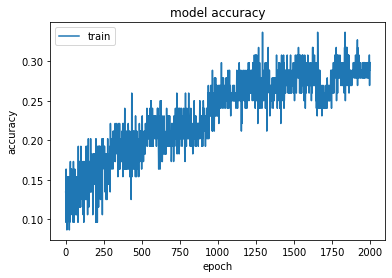

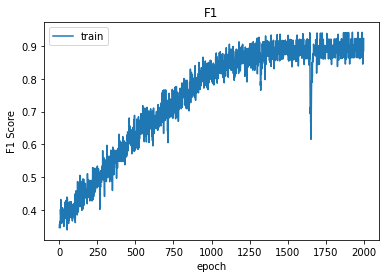

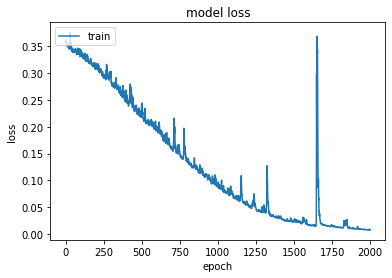

In [ ]:
history = model.fit(X_train, y_train, epochs=2000, verbose=0)
# Fit the model
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for f1
plt.plot(history.history['f1'])
plt.title('F1')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred_ori = model.predict(X_test)

In [ ]:
y_pred = np.where(y_pred_ori >= 0.2, 1, 0)

In [ ]:
f1(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.2823313>

In [ ]:
utils.confusion_matrix(y_true, y_pred)

Confusion Matrix
 [[200  60]
 [ 46  32]]
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.33      0.30      0.32        10
           2       0.40      0.50      0.44         8
           3       0.25      0.25      0.25         4
           4       0.00      0.00      0.00         1
           5       0.36      0.45      0.40        11
           6       0.29      0.67      0.40         6
           7       0.29      0.33      0.31         6
           8       0.00      0.00      0.00         0
           9       0.20      0.40      0.27         5
          10       0.00      0.00      0.00         1
          11       0.64      0.70      0.67        10
          12       0.60      0.23      0.33        13

   micro avg       0.35      0.41      0.38        78
   macro avg       0.28      0.32      0.28        78
weighted avg       0.39      0.41      0.38        78
 samples avg       0.34      0.41      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pltX = []
pltY = []

for name2,data2 in second.items():

    row = [name2]
    for name1,data1 in first.items():
        data = np.stack((data1, data2), axis=1)
        loss = K.eval(f1_loss(Y, data))
        f1 = f1_score(Y, data, average='macro')
        pltX.append(loss)
        pltY.append(f1)
        row.append('{:2f}\n{:2f}'.format(loss, f1))

NameError: ignored